# PCA - Implement

## PCA - Introduction 

- Đúng như với mục đích của PCA giảm chiều dữ liệu của một vector m chiều xuống còn k chiều  
- Như vậy ta có thể sử dụng PCA vào các trường hợp 
    + Các bài toán học máy đơn giản , ví dụ X có m đặc trưng , ta muốn giảm nó xuống k đặc trưng . Nghĩa là X có m đặc trưng ví dụ loài hoa thì có chiều dài , màu sắc ,... gồm m đặc trưng như thế sau đó ta sẽ giảm chiều nó xuống thành k đặc trưng 
    + Đối với bài toán nhận diện ảnh vì ảnh được chuyển thành một matrix hoặc tensor . Mặc khác với các model Deep learning thì đầu vào của nó cũng yêu cầu là một matrix hoặc tensor (matrix hoặc tensor fixcel của ảnh) , chính vì thế mà nó thường không được áp dụng cho ảnh . <strong style="color:yellow">Mà nó thường được áp dụng trong Transfer learning . Cụ thể là sau các lớp Conv , trước khi đến các lớp FCs thì ta cho qua PCA để giảm chiều . Ví dụ đầu ra của VGG sau khi qua flatten (làm phẳng) là một vector với số chiều là (4096,1) ta sẽ cho nó qua PCA trở thành (k,1) với k là số chiều được giảm xuống, sau đó mới cho qua các lớp FCs ví dụ như Dense(512,sigmoid) rồi Dense(10,softmax)</strong>

- <strong style="color:#FFC107">Một lưu ý cực kì quan trọng trong PCA là nếu X có shape là (n,m) thì k phải <= n,m thì mới áp dụng PCA được . Với k là số chiều muốn giảm xuống</strong>

## Code

#### PCA

In [108]:
# Đây là thuật toán PCA
# Input: Dữ liệu đầu vào là một ma trận X (n x m) với n là số lượng mẫu, m là số chiều của mỗi mẫu
# Output: Ma trận X sau khi giảm chiều về k chiều (n x k)
# Cách sử dụng:
# pca = PCA(X, k)
# pca.fit()
# X_new = pca.transform(X)
# Trong đó X_new là ma trận X sau khi giảm chiều về k chiều

import numpy as np

class PCA:
    def __init__(self, X, k):
        self.X = X
        self.k = k
        self.n, self.m = X.shape
        self.mean = np.mean(X, axis=0)
        self.X = self.X - self.mean
        self.cov = np.dot(self.X.T, self.X) / self.n
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.cov)
        self.eigenvalues_idx = np.argsort(self.eigenvalues)[::-1]
        
    def fit(self):
        self.eigenvalues = np.real(self.eigenvalues)
        self.eigenvectors = np.real(self.eigenvectors)
        self.eigenvectors = self.eigenvectors[:, self.eigenvalues_idx]
        self.eigenvectors = self.eigenvectors[:, :self.k]
        
    def transform(self, X):
        return np.dot(X - self.mean, self.eigenvectors)
    
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.eigenvectors.T) + self.mean
    
    # tính phương sai
    def variance(self):
        return np.sum(self.eigenvalues[:self.k]) / np.sum(self.eigenvalues)

    def get_eigenvectors(self):
        return self.eigenvectors
    
    def get_mean(self):
        return self.mean

#### Load dữ liệu

In [109]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load dữ liệu MNIST từ scikit-learn
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype(int)

print('X.shape', X.shape)
print('y.shape', y.shape)
print(type(X)) # <class 'pandas.core.frame.DataFrame'>
X = X.values
print(type(X)) # <class 'numpy.ndarray'>

X.shape (70000, 784)
y.shape (70000,)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


#### Cách tìm ra k tốt nhất 

- Khác với việc dùng thư viện , code thuần sẽ train lâu hơn nếu cho giảm xuống đúng số chiều mà X đang có , chính vì thế dùng phương pháp khoanh vùng
- Có thể khoanh vùng bằng step 
    + Ban đầu cho start và end là một vùng lớn , step cũng lớn , ví dụ (start=1, end = 784, step = 10)
    + Sau đó khoang vùng start và end càng ngàng càng nhỏ lại và step cũng nhỏ lại (start = 500, end = 600, step = 1)

- Thay vì (start=1, end = 784, step = 1) => lâu 
- Với cách này có thể tìm ra k tối ưu nhất 

Ví dụ : Với yêu cầu là accuracy % (95% - 99%) , ví dụ accuracy = 0.95 
- Ban đầu cho : (start=1, end = 784, step = 10) => tìm được best_k = 161 
- => Nó sẽ nằm trong phạm vi 151 - 161 - 171 => (start=151, end = 171, step = 1) => tìm ra best_k cuối cùng = 154

- Kết qủa giống với thư viện , thư viện tìm ra là 153 (do làm tròn nên có thể chênh nhau)

In [110]:
# Danh sách để lưu trữ các giá trị phương sai
# X có shape = (n,m)
cumulative_variance_ratio = []
accuracy = 0.95 

# step 1 
# start = 1
# end = X.shape[1] 
# step = 10
# => best_k_of_accuracy = 161

# step2
start = 151
end = 171 
step = 1
# => best_k_of_accuracy = 154

best_k_of_accuracy = X.shape[1] 
for k in range(start, end, step):
    pca = PCA(X, k)
    pca.fit()
    variance = pca.variance()
    print('k :',k, 'variance :',variance)
    cumulative_variance_ratio.append(variance)
    if variance >= accuracy :
        best_k_of_accuracy = k 
        end = k 
        break # thoát for 

print("Best k of accuracy:", best_k_of_accuracy)

k : 151 variance : 0.9489801906329886
k : 152 variance : 0.9494421826459516
k : 153 variance : 0.9499004670919698
k : 154 variance : 0.9503499702078614
Best k of accuracy: 154


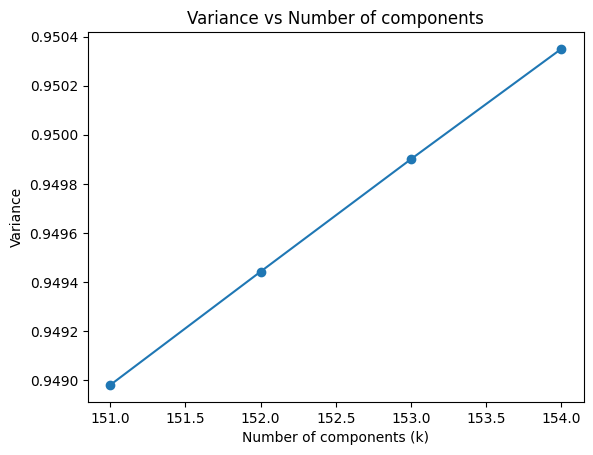

In [114]:
# Vẽ đồ thị phương sai
plt.plot(range(start, end+1, step), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of components (k)')
plt.ylabel('Variance')
plt.title('Variance vs Number of components')
plt.show()